# Impacto das Contratações em um Clube de Futebol
### MVP de Engenharia de Dados
#### Aluno: Guilherme Freitas França
#### Instituição: PUC-Rio

## 1. Introdução e Definição do Problema

### 1.1 Introdução

No mundo altamente competitivo do futebol profissional, a aquisição de novos jogadores é uma estratégia fundamental para clubes que buscam melhorar seu desempenho e alcançar sucesso em competições. As contratações, sejam elas de jovens promessas ou de jogadores experientes, têm o potencial de transformar significativamente a dinâmica de uma equipe, influenciando não apenas o desempenho em campo, mas também a moral do time, a estratégia do treinador e o entusiasmo dos torcedores.

Este trabalho tem como objetivo avaliar o impacto das contratações no desempenho de clubes de futebol, explorando como a quantidade de contratações e suas características impactam o desempenho dos times em suas temporadas. Para tal, será modelado um pipeline de dados utilizando tecnologias escaláveis em nuvem para suportar futuramente análises mais refinadas e em maior escala.

### 1.2 Sobre o Dataset

Para realizar a análise do impacto das contratações no desempenho dos clubes de futebol, foram escolhidos dois datasets obtidos no Kaggle: **Performance Data on Football teams 09 to 22** e **Football Transfers (Major Leagues)**. Esses datasets fornecem uma base robusta de informações sobre o desempenho das equipes e as transferências de jogadores, permitindo uma análise detalhada e abrangente.

### Performance Data on Football teams 09 to 22

**Sobre o Dataset:**
"Este <a href='https://www.kaggle.com/datasets/gurpreetsdeol/performance-data-on-football-teams-09-to-22/data'>dataset</a> foi coletado de websites de dados de futebol, abrangendo as temporadas de 2009/10 a 2021/22. Ele contém estatísticas de temporada e dados de desempenho, incluindo atributos relacionados a passes e chutes. A maior parte dos dados refere-se às cinco principais ligas da Europa, bem como à Liga dos Campeões. É importante notar que algumas colunas podem estar ausentes em determinadas temporadas devido à indisponibilidade de dados ou à não coleta de informações em anos anteriores."

**Licença:**
O autor não fornece nenhuma informação adicional acerca da licença de uso ou até detalhes da obtenção dos dados.


### Football Transfers (Major Leagues)

**Sobre o Dataset:**
Este <a href='https://www.kaggle.com/datasets/ashishmotwani/football-transfers'>dataset</a> inclui todas as transferências de clubes de futebol desde 1993. O dataset oferece uma visão abrangente das movimentações de jogadores, permitindo uma análise detalhada das tendências de transferências e seu impacto nos clubes.

**Licença:**
Os dados foram disponibilizados para uso público no Kaggle, e segundo o autor, todos os dados das equipes foram extraídos do Transfermarkt, em conformidade com os termos de uso do site.

### Características dos Datasets

- **Período Coberto:**
  - Dataset de performance: Temporadas de 2009/10 a 2021/22.
  - Dataset de transferência: Transferências de 1993 a 2022.

- **Atributos:**
  - Dataset de performance: Nome do clube, torneio, temporada, posição final no torneio, número de vitórias, derrotas e empates, etc.
  - Dataset de transferência: Nome dos clubes envolvidos, nome do jogador, idade do jogador, posição, temporada, etc.

Esses datasets fornecem a base necessária para explorar a relação entre contratações de jogadores e o desempenho dos clubes, possibilitando insights valiosos para a gestão esportiva e a análise de futebol.

### 1.3 Perguntas e Hipóteses

Este trabalho busca responder a várias perguntas chave sobre o impacto das contratações no desempenho dos clubes de futebol. Dentre as principais questões estão:

- **Os times que mais contratam jogadores são os que melhores desempenham?**
  - **Hipótese:** Times que contratam mais jogadores têm um desempenho superior devido ao aumento da qualidade e profundidade do elenco.

- **Os times que mais gastam com contratações são os que melhores desempenham?**
  - **Hipótese:** O maior investimento financeiro em contratações esta relacionado a um desempenho melhorado, pois jogadores de maior valor tendem a ser mais habilidosos e experientes.

- **Existe alguma relação entre a perda de jogadores e o desempenho de um time?**
  - **Hipótese:** A saída de jogadores chave impacta negativamente o desempenho do time, especialmente se esses jogadores tiverem um papel crucial na equipe.


Estas perguntas e hipóteses guiarão a análise dos datasets, ajudando a revelar padrões e relações significativas entre as contratações de jogadores e o desempenho dos clubes. Ao testar essas hipóteses, esperamos fornecer insights valiosos que possam informar estratégias de contratação e gestão esportiva no futebol.


# 2. Criação do Pipeline de Dados

Inicia-se o código importando as bibliotecas que serão utilizadas, assim como criando a sessão do Spark para a manipulação e comunicação com a plataforma Databricks.

Além disso, é criado o Database do pipeline de dados.

In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf, monotonically_increasing_id, when, lit
from pyspark.sql.types import BooleanType, StringType

import unicodedata
import re

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # classe Retangulo para ajudar na visualização
import seaborn as sns

sns.set(style="whitegrid")


# Inicialize o SparkSession
spark = SparkSession.builder.appName("MVP3 Pipeline").getOrCreate()

# Definir o nome do banco de dados
DATABASE_NAME = "MVP3"

# APENAS TRUE POR MOTIVOS DE DEBUG
CLEAN_START = True

if CLEAN_START and spark.catalog.databaseExists(DATABASE_NAME):
    # Listar todas as tabelas e views dentro do banco de dados
    tables = spark.catalog.listTables(DATABASE_NAME)

    # Excluir todas as tabelas
    for table in tables:
        spark.sql(f"DROP TABLE IF EXISTS {DATABASE_NAME}.{table.name}")

# Criar um banco de dados no Databricks
spark.sql("CREATE DATABASE IF NOT EXISTS MVP3")

Out[1]: DataFrame[]

## 2.1 Constantes

In [0]:
# Definindo a ordem desejada para as categorias de performance
PERFORMANCE_ORDER = {'Performance': ['High Performers', 'Mid Performers', 'Low Performers'],
                     'season': ['2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022']}

# Definindo cores personalizadas para cada categoria
PERFORMANCE_COLORS = {'High Performers': 'rgba(51, 160, 44, 0.7)',   # Verde com alpha
          'Mid Performers': 'rgba(255, 153, 51, 0.7)',  # Laranja com alpha
          'Low Performers': 'rgba(220, 57, 18, 0.7)'}   # Vermelho com alpha

## 2.2 Funções Auxiliares

Aqui estão algumas funções auxiliares que serão utilizadas no decorrer do notebook

In [0]:
# Função para normalizar rank
def normalizar_rank(grupo):
    min_val = grupo['Rank'].min()
    max_val = grupo['Rank'].max()
    grupo['Rank_norm'] = 1 - ((grupo['Rank'] - min_val) / (max_val - min_val))
    return grupo

In [0]:
# Função para remover "FC", fazer trim e remover acentos
def clean_club_name(club_name):
    # Remover "FC" se estiver presente (case insensitive)
    club_name = re.sub(r'\bFC\b', '', club_name, flags=re.IGNORECASE)
    # Remover espaços em branco no início e final
    club_name = club_name.strip()
    # Remover acentos usando unicodedata
    club_name = ''.join(c for c in unicodedata.normalize('NFKD', club_name) if not unicodedata.combining(c))
    return club_name

In [0]:
# Definir função personalizada para encontrar o time correspondente
def find_matched_team(team, teams_set):
    team_words = set(team.lower().split())
    
    for unique_team in teams_set:
        unique_team_words = set(unique_team.lower().split())
        if unique_team_words.issubset(team_words) or team_words.issubset(unique_team_words):
            return unique_team
    return  team

In [0]:
# Definir função personalizada para filtragem
def is_valid_combined_row(matched_club_name, matched_club_involved_name):
    return matched_club_name in unique_teams_set or matched_club_involved_name in unique_teams_set

# 3. Camada Bronze

É a camada de ingestão, onde os dados brutos são armazenados exatamente como chegam, sem transformações. Seu objetivo é garantir a persistência dos dados originais para possíveis consultas e auditorias.

### 3.1 Carga dos dados principais

Os datasets foram baixados do Kaggle e disponiblizados em um <a href="https://github.com/gffranca/DataAnalytics/tree/main/MVP3">repositório público do GitHub</a>. Dessa forma podem ser carregados diretamente de seus arquivos raw.

In [0]:

# URLs dos datasets
performance_url = "https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/performance_raw_data/Complete%20Dataset%202.csv"
transfer_base_url = "https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/{0}.csv"
transfer_urls = ["1-bundesliga", 
 "championship", 
 "eredivisie", 
 "liga-nos", 
 "ligue-1", 
 "premier-league", 
 "premier-liga", 
 "primera-division", 
 "serie-a"]


In [0]:
raw_url_sources = { "bronze_performance": performance_url }
for i, url in enumerate(transfer_urls):
    database_tag = "bronze_transfer_" + str(i + 1)
    raw_url_sources[database_tag] = transfer_base_url.format(url)

raw_url_sources

Out[8]: {'bronze_performance': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/performance_raw_data/Complete%20Dataset%202.csv',
 'bronze_transfer_1': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/1-bundesliga.csv',
 'bronze_transfer_2': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/championship.csv',
 'bronze_transfer_3': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/eredivisie.csv',
 'bronze_transfer_4': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/liga-nos.csv',
 'bronze_transfer_5': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/ligue-1.csv',
 'bronze_transfer_6': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer_raw_data/premier-league.csv',
 'bronze_transfer_7': 'https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/transfer

In [0]:
for source_key in raw_url_sources:
    # Leitura de dados CSV a partir da URL usando pandas
    df_pandas = pd.read_csv(raw_url_sources[source_key])

    # Converter o dataframe pandas para um dataframe Spark
    df_spark = spark.createDataFrame(df_pandas)

    # Persistir dados na camada Bronze como uma tabela Delta no banco de dados
    df_spark.write.format("delta").mode("overwrite").saveAsTable("MVP3." + source_key)

### 3.2 Características dos dados

O Dataset de Performance contém diversos atributos que não serão utilizados neste MVP e o autor do dataset não fornece informações detalhadas sobre os atributos. Apesar disso, todos eles estão descritos aqui, simulando uma etapa de um processo real de carga de dados.

### 3.2.1  Dataset de Performance

| Atributo                          | Descrição                                                      |
|-----------------------------------|----------------------------------------------------------------|
| **Key**                           | Identificador único do registro                                |
| **Team**                          | Nome da equipe                                                 |
| **League**                        | Liga na qual a equipe compete                                  |
| **Season**                        | Temporada correspondente aos dados                             |
| **Rank**                          | Posição da equipe na tabela de classificação                   |
| **Games**                         | Número total de jogos disputados                               |
| **Wins**                          | Número de vitórias                                             |
| **Draws**                         | Número de empates                                              |
| **Losses**                        | Número de derrotas                                             |
| **Points**                        | Pontos totais acumulados                                       |
| **GoalsFor**                      | Número de gols marcados pela equipe                            |
| **GoalsAgainst**                  | Número de gols sofridos pela equipe                            |
| **GoalDifference**                | Diferença entre gols marcados e sofridos                       |
| **Goals**                         | Total de gols marcados                                         |
| **Possession**                    | Percentual de posse de bola                                    |
| **PassSuccess**                   | Percentual de passes bem-sucedidos                             |
| **CrossesPerGame**                | Média de cruzamentos por jogo                                  |
| **ThroughBallsPerGame**           | Média de passes entre linhas por jogo                          |
| **LongBallsPerGame**              | Média de lançamentos longos por jogo                           |
| **ShortPassesPerGame**            | Média de passes curtos por jogo                                |
| **OpenPlayGoals**                 | Número de gols em jogadas de bola rolando                      |
| **CounterAttackGoals**            | Número de gols em contra-ataques                               |
| **SetPieceGoals**                 | Número de gols em jogadas de bola parada                       |
| **PenaltyGoals**                  | Número de gols de pênalti                                      |
| **OwnGoals**                      | Número de gols contra                                          |
| **TotalTacklesPerGame**           | Média total de desarmes por jogo                               |
| **DribbledPastPerGame**           | Média de vezes que jogadores adversários passaram pela defesa  |
| **TotalAttemptedTacklesPerGame**  | Média total de tentativas de desarme por jogo                  |
| **InterceptionsPerGame**          | Média de interceptações por jogo                               |
| **FouledPerGame**                 | Média de vezes que a equipe sofreu faltas                      |
| **FoulsPerGame**                  | Média de faltas cometidas pela equipe por jogo                 |
| **YellowCardPerGame**             | Média de cartões amarelos por jogo                             |
| **RedCardPerGame**                | Média de cartões vermelhos por jogo                            |
| **OffsidesPerGame**               | Média de impedimentos por jogo                                 |
| **ClearancesPerGame**             | Média de cortes por jogo                                       |
| **ShotsBlockedPerGame**           | Média de chutes bloqueados por jogo                            |
| **CrossesBlockedPerGame**         | Média de cruzamentos bloqueados por jogo                       |
| **TotalSavesPerGame**             | Média total de defesas por jogo                                |
| **SixYardSavesPerGame**           | Média de defesas dentro da pequena área por jogo               |
| **PenaltyAreaSavesPerGame**       | Média de defesas na área do pênalti por jogo                   |
| **OutOfBoxSavesPerGame**          | Média de defesas fora da área do pênalti por jogo              |
| **TotalShotsPerGame**             | Média total de chutes por jogo                                 |
| **OutOfBoxShotsPerGame**          | Média de chutes fora da área por jogo                          |
| **SixYardBoxShotsPerGame**        | Média de chutes dentro da pequena área por jogo                |
| **PenaltyAreaShotsPerGame**       | Média de chutes na área do pênalti por jogo                    |
| **GoalsPerGame**                  | Média de gols por jogo                                         |
| **SixYardGoalsPerGame**           | Média de gols dentro da pequena área por jogo                  |
| **PenaltyAreaGoalsPerGame**       | Média de gols na área do pênalti por jogo                      |
| **OutOfBoxGoalsPerGame**          | Média de gols fora da área por jogo                            |
| **UnsuccessfulDribblesPerGame**   | Média de dribles malsucedidos por jogo                         |
| **SuccessfulDribblesPerGame**     | Média de dribles bem-sucedidos por jogo                        |
| **TotalDribblesPerGame**          | Média total de dribles por jogo                                |
| **DisspossedPerGame**             | Média de vezes que a equipe perdeu a posse de bola por jogo    |
| **TotalAerialDuelsPerGame**       | Média total de duelos aéreos por jogo                          |
| **AerialDuelsWonPerGame**         | Média de duelos aéreos vencidos por jogo                       |
| **AerialDuelsLostPerGame**        | Média de duelos aéreos perdidos por jogo                       |
| **TotalPassesPerGame**            | Média total de passes por jogo                                 |
| **AccurateLongBallsPerGame**      | Média de lançamentos longos precisos por jogo                  |
| **InAccurateLongBallsPerGame**    | Média de lançamentos longos imprecisos por jogo                |
| **AccShortPassesPerGame**         | Média de passes curtos precisos por jogo                       |
| **InAccurateShortPassesPerGame**  | Média de passes curtos imprecisos por jogo                     |
| **TotalKeyPassesPerGame**         | Média total de passes-chave por jogo                           |
| **LongKeyPassesPerGame**          | Média de passes-chave longos por jogo                          |
| **ShortKeyPassesPerGame**         | Média de passes-chave curtos por jogo                          |
| **CrossAssistPerGame**            | Média de assistências em cruzamentos por jogo                  |
| **CornerAssistPerGame**           | Média de assistências em escanteios por jogo                   |
| **ThroughballAssistPerGame**      | Média de assistências em passes entre linhas por jogo          |
| **FreekickAssistPerGame**         | Média de assistências em cobranças de falta por jogo           |
| **ThrowInAssistPerGame**          | Média de assistências em cobranças de lateral por jogo         |
| **OtherAssistPerGame**            | Média de outras assistências por jogo                          |
| **TotalAssistPerGame**            | Média total de assistências por jogo                           |
| **ShotsOnTarget**                 | Número total de chutes a gol                                   |
| **ShotsOnTargetAgainst**          | Número total de chutes a gol sofridos                          |
| **ShotsOnTargetPer90**            | Média de chutes a gol por 90 minutos                           |
| **ShotsOnTargetAgainstPer90**     | Média de chutes a gol sofridos por 90 minutos                  |
| **Touches**                       | Número total de toques na bola                                 |
| **TouchesDefPen**                 | Número de toques na área defensiva                             |
| **TouchesDefThird**               | Número de toques no terço defensivo                            |
| **TouchesMidThird**               | Número de toques no terço médio                                |
| **TouchesAttThird**               | Número de toques no terço ofensivo                             |
| **TouchesAttPen**                 | Número de toques na área ofensiva                              |
| **LiveTouches**                   | Número de toques na bola em jogadas de bola rolando            |
| **NumOfPlayersDribbledPast**      | Número de jogadores adversários driblados                      |
| **Nutmegs**                       | Número de dribles por entre as pernas do adversário            |
| **Controlled**                    | Número de bolas controladas                                    |
| **DistMovedWithBall**             | Distância total percorrida com a bola                          |
| **ProgressiveDistMoved**          | Distância progressiva percorrida com a bola                    |
| **ProgC**                         | Passes progressivos completados                                |
| **ProgressiveIntoFinalThird**     | Passes progressivos no terço final do campo                    |
| **ProgressiveInto18Yard**         | Passes progressivos na área do pênalti                         |
| **Miscontrols**                   | Número de vezes que a bola foi mal controlada                  |
| **MiscontrolsAfterTackle**        | Número de vezes que a bola foi mal controlada após um desarme  |
| **ProgressivePassReceived**       | Número de passes progressivos recebidos                        |


### 3.2.2 Dataset de Transferências

| Atributo               | Descrição                                                             |
|------------------------|-----------------------------------------------------------------------|
| **club_name**          | Nome do clube                                                         |
| **player_name**        | Nome do jogador                                                       |
| **age**                | Idade do jogador                                                      |
| **position**           | Posição em que o jogador atua                                         |
| **club_involved_name** | Nome do outro clube envolvido na transferência                        |
| **fee**                | Valor da transferência                                                |
| **transfer_movement**  | Tipo de movimento da transferência (entrada ou saída)                 |
| **transfer_period**    | Período da transferência (janela de transferência)                    |
| **fee_cleaned**        | Valor da transferência normalizado                                    |
| **league_name**        | Nome da liga do clube                                                 |
| **year**               | Ano da transferência                                                  |
| **season**             | Temporada correspondente à transferência                              |


# 4. Camada Silver

Nesta camada, os dados são refinados e limpos. Aplicam-se transformações para corrigir, padronizar e enriquecer os dados, tornando-os mais estruturados e consistentes. A camada Silver serve como base para análises e relatórios mais detalhados.

## 4.1 Manipulação inicial dos dados

Primeiramente, como o dataset de transferência estava separado por campeonatos, ele precisam ser juntados em um unico dataset.

In [0]:
# Leitura e união das tabelas
combined_transfer = None
transfer_url_sources = {k: v for k, v in raw_url_sources.items() if "transfer" in k}

for source_key in transfer_url_sources:
    df = spark.read.format("delta").table(f"MVP3.{source_key}")
    if combined_transfer is None:
        combined_transfer = df
    else:
        combined_transfer = combined_transfer.union(df)

combined_transfer.write.format("delta").mode("overwrite").saveAsTable("MVP3.bronze_transfers")

In [0]:
# Leitura da tabela de performance de times da camada Bronze
df_bronze_performance = spark.read.format("delta").table("MVP3.bronze_performance").toPandas()
df_combined_transfer = spark.read.format("delta").table("MVP3.bronze_transfers").toPandas()

In [0]:
# Aplicar a função clean_club_name à coluna 'Clube'
df_bronze_performance['Team'] = df_bronze_performance['Team'].apply(clean_club_name)
df_combined_transfer['club_name'] = df_combined_transfer['club_name'].apply(clean_club_name)
df_combined_transfer['club_involved_name'] = df_combined_transfer['club_involved_name'].apply(clean_club_name)

Além disso, precisa ser feito um filtro no dataset de transferências para garantir uma integridade semântica. Serão mantidas apenas as transferências que envolvem clubes presentes no dataset de performance, uma vez que não é de interesse avaliar transferências de clubes sem dados de performance (de outras  ligas por exemplo). 

Pode haver uma certa perda de informações pois como são dataset diferentes, alguns clubes podem ter seus nomes ligeiramente diferentes, como por ex.: 'Sevilla' e 'Sevilla FC'. Para não tratá-los como diferentes, são realizadas transformações no nome do clube para encontrar um par para ele. Este método não é o melhor e alguns clubes não são encontrados, como é o caso de: 'Inter FC' e 'FC Internazionale'.

In [0]:
# Obter lista única de times da tabela de performance
unique_teams = df_bronze_performance["Team"].unique().tolist()

# Converter lista para set para melhorar a performance de busca
unique_teams_set = set(unique_teams)

# Registrar a função UDF
find_matched_team_udf = udf(lambda team: find_matched_team(team, unique_teams_set), StringType())

# Aplicar a função para criar novas colunas com os nomes substituídos
df_combined_transfer = spark.createDataFrame(df_combined_transfer)
df_combined_transfer = df_combined_transfer.withColumn("matched_club_name", find_matched_team_udf(col("club_name")))
df_combined_transfer = df_combined_transfer.withColumn("matched_club_involved_name", find_matched_team_udf(col("club_involved_name")))

# Registrar a função UDF
is_valid_combined_row_udf = udf(is_valid_combined_row, BooleanType())

# Filtrar a tabela combinada usando a função personalizada
df_combined_transfer = df_combined_transfer.filter(is_valid_combined_row_udf(col("matched_club_name"), col("matched_club_involved_name")))

In [0]:
# Substituir as colunas originais pelas colunas matched
df_combined_transfer = df_combined_transfer.drop("club_name", "club_involved_name")
df_combined_transfer = df_combined_transfer.withColumnRenamed("matched_club_name", "club_name")
df_combined_transfer = df_combined_transfer.withColumnRenamed("matched_club_involved_name", "club_involved_name")

In [0]:
df_combined_filtered = df_combined_transfer.toPandas()

É importante realizar uma análise descritiva para avaliar a qualidade dos dados. Para isso, utilizamos a função _describe()_ do DataFrame pandas.

In [0]:
df_bronze_performance.describe()

,Rank,Games,Wins,Draws,Losses,Points,GoalsFor,GoalsAgainst,GoalDifference,Goals,...,Nutmegs,Controlled,DistMovedWithBall,ProgressiveDistMoved,ProgC,ProgressiveIntoFinalThird,ProgressiveInto18Yard,Miscontrols,MiscontrolsAfterTackle,ProgressivePassReceived
count,1688.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.00000,1690.000000,...,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,13.212085,37.105346,13.860849,9.390723,13.853774,50.938679,50.680818,50.660377,0.02044,40.983432,...,0.634735,387.399388,1998.687755,1078.070408,42.133265,12.833490,3.788367,12.558796,11.431082,37.093265
std,11.652804,1.936824,5.839471,2.944652,5.338193,16.656978,16.698945,12.701106,25.64368,22.574074,...,0.241344,82.678298,410.154133,244.932767,11.668808,3.202049,1.304016,1.254332,1.346927,8.074744
min,1.000000,27.000000,2.000000,2.000000,0.000000,13.000000,20.000000,17.000000,-61.00000,0.000000,...,0.110000,212.200000,1050.300000,537.500000,21.900000,6.790000,1.530000,8.390000,8.660000,18.100000
25%,6.000000,38.000000,10.000000,7.000000,10.000000,40.000000,39.000000,42.000000,-17.00000,27.000000,...,0.470000,329.925000,1717.275000,912.625000,34.325000,10.400000,2.767500,11.700000,10.400000,31.100000
50%,12.000000,38.000000,12.000000,9.000000,14.000000,47.000000,47.000000,51.000000,-4.00000,42.000000,...,0.610000,371.050000,1944.300000,1047.150000,40.200000,12.400000,3.545000,12.600000,11.400000,36.750000
75%,17.000000,38.000000,17.000000,11.000000,18.000000,61.000000,59.000000,59.000000,14.00000,54.000000,...,0.790000,431.850000,2244.800000,1226.625000,48.100000,14.475000,4.625000,13.400000,12.300000,41.600000
max,323.000000,38.000000,33.000000,19.000000,29.000000,102.000000,121.000000,94.000000,89.00000,121.000000,...,1.840000,636.900000,3322.100000,1920.300000,87.800000,25.700000,9.970000,15.900000,15.300000,67.200000


Observando as características dos dados, chama a atenção o Rank máximo do dataset: 323. Isto significaria, que um time ficou na posição 323. 

Este dado não parece estar correto. Uma possível solução para este problema seria remover os dados cujo ranking é maior que o maior número de times em uma liga. Apesar disso, foi decidido restringir o valor máximo ao valor aceitável para este atributo.

No caso, a pior posição que um time poderia estar nos torneios considerados seria em 32º. 

In [0]:
df_bronze_performance['Rank'] = df_bronze_performance['Rank'].clip(upper=32)

O número ordinal da posição final do time tem sentido completo quando sabemos quantos times disputavam aquele campeonato. Por isso, para que a sua posição tenha um valor comparável entre outros times em termos de desempenho, foi normalizado o rank dos times considerando cada liga separadamente.

In [0]:
# Aplicar a padronização dentro de cada grupo
df_bronze_performance = df_bronze_performance.groupby('League').apply(normalizar_rank)

## 4.2 Limpeza e Controle

Para iniciar o tratamento de _missings_, é importante ter uma noção de quais atributos não possuem valor.

In [0]:
dict(df_bronze_performance.isnull().sum())

Out[19]: {'Key': 0,
 'Team': 0,
 'League': 0,
 'Season': 0,
 'Rank': 2,
 'Games': 418,
 'Wins': 418,
 'Draws': 418,
 'Losses': 418,
 'Points': 418,
 'GoalsFor': 418,
 'GoalsAgainst': 418,
 'GoalDifference': 418,
 'Goals': 0,
 'Possession': 0,
 'PassSuccess': 0,
 'CrossesPerGame': 0,
 'ThroughBallsPerGame': 0,
 'LongBallsPerGame': 0,
 'ShortPassesPerGame': 0,
 'OpenPlayGoals': 0,
 'CounterAttackGoals': 0,
 'SetPieceGoals': 0,
 'PenaltyGoals': 0,
 'OwnGoals': 0,
 'TotalTacklesPerGame': 0,
 'DribbledPastPerGame': 0,
 'TotalAttemptedTacklesPerGame': 0,
 'InterceptionsPerGame': 0,
 'FouledPerGame': 0,
 'FoulsPerGame': 0,
 'YellowCardPerGame': 0,
 'RedCardPerGame': 0,
 'OffsidesPerGame': 0,
 'ClearancesPerGame': 0,
 'ShotsBlockedPerGame': 0,
 'CrossesBlockedPerGame': 0,
 'TiotalSavesPerGame': 0,
 'SixYardSavesPerGame': 0,
 'PenaltyAreaSavesPerGame': 0,
 'OutOfBoxSavesPerGame': 0,
 'TotalShotsPerGame': 0,
 'OutOfBoxShotsPerGame': 0,
 'SixYardBoxShotsPerGame': 0,
 'PenaltyAreaShotsPerGame': 0,

In [0]:
df_combined_filtered.isnull().sum()

Out[20]: player_name               0
age                      50
position                  0
fee                      60
transfer_movement         0
transfer_period           0
fee_cleaned           82566
league_name               0
year                      0
season                    0
club_name                 0
club_involved_name        0
dtype: int64

Avaliando os atributos que possuem missing, percebemos que na tabela de performance, varios atributos possuem dados faltantes. Entretanto, não está sendo avaliado diretamente todos os atributos de performance, o principal é o de Rank, que denota a posição final de um time em um torneio em uma determinada temaporada. Por isso, as colunas que não possuem valor de Rank serão removidas, e os demais valores em branco serão preenchidos com 0.

Já no dataset de transferências, o número de missings se concentra no atributo fee, que denota o custo de uma transferência. Em alguns casos a transferência de um jogador não tem custos, as vezes por empréstimos ou até com o fim de um contrato. Por isso, serão preenchidos também com 0 os valores restantes.

In [0]:
# problemas do dataset
df_bronze_performance = df_bronze_performance.dropna(subset=['Rank', 'Games'])

# Substituir valores nulos por 0, caso existam temporadas sem transferências
df_bronze_performance = df_bronze_performance.fillna(0)
df_combined_filtered.fillna(0, inplace=True)

In [0]:
# Persistir dados filtrados na camada Silver
spark.createDataFrame(df_bronze_performance).write.format("delta").mode("overwrite").saveAsTable("MVP3.silver_performance")
spark.createDataFrame(df_combined_filtered).write.format("delta").mode("overwrite").saveAsTable("MVP3.silver_transfers")

/databricks/spark/python/pyspark/sql/pandas/conversion.py:467: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Expected bytes, got a 'int' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


## 4.3 Problemas Encontrados e Possíveis soluções

Dentre os problemas encontrados até então, dois se destacam como os principais:

- **Falta de Descrições de Atributos nos Datasets:** Os datasets carecem de um catálogo de dados que explique o significado de cada atributo. Isso dificulta a compreensão e o uso dos dados de maneira eficaz. Para resolver este problema, considera-se as seguintes abordagens:

    - Buscar outro dataset que contenha um catálogo de dados detalhado.
    - Realizar scraping das fontes originais para criar um catálogo de dados completo.

- **Inconsistências na Identificação de Clubes de Futebol entre Datasets:** A identificação dos clubes de futebol nos datasets é inconsistente, com variações nos nomes dos clubes, como 'Inter FC' e 'FC Internazionale'. Essas discrepâncias levam a comparações diretas de strings que consideram clubes diferentes, embora se refiram ao mesmo clube na realidade. Para resolver este problema, considera-se as seguintes abordagens:

    - Aplicar técnicas de Processamento de Linguagem Natural (NLP), como modelos de linguagem (LLMs), para melhorar a correspondência entre os nomes dos clubes.
    - Melhorar o processo de obtenção de dados, garantindo que os nomes dos clubes sejam consistentemente capturados e padronizados desde a fonte.

# 5. Camada Gold

É a camada mais refinada, onde os dados são otimizados para análises avançadas e relatórios de negócios. Aqui, os dados são agregados, filtrados e modelados de acordo com as necessidades específicas do negócio, proporcionando insights valiosos e suportando decisões estratégicas.

## 5.1 Modelagem e Finalizações

Para a modelagem dos dados, foi escolhido o modelo de constelação de fatos para lidar com os dois datasets escolhidos.

<img src="https://raw.githubusercontent.com/gffranca/DataAnalytics/main/MVP3/data/images/constelation.png" width="800"/>
</div>

In [0]:
df_silver_performance = spark.read.table("MVP3.silver_performance")
df_silver_transfer = spark.read.table("MVP3.silver_transfers")

In [0]:
# Dimensão Team_Dimension
team_dimension = df_silver_performance.select("team").distinct().withColumn("team_key", monotonically_increasing_id())
team_dimension.createOrReplaceTempView("team_dimension")

# Dimensão Time_Dimension
time_dimension = df_silver_performance.select("season").distinct().withColumn("time_key", monotonically_increasing_id())
time_dimension.createOrReplaceTempView("time_dimension")

# Dimensão League_Dimension
league_dimension = df_silver_performance.select("league").distinct().withColumn("league_key", monotonically_increasing_id())
league_dimension.createOrReplaceTempView("league_dimension")

In [0]:
# Adicionar chaves estrangeiras às tabelas de performance
performance_fact = df_silver_performance.join(team_dimension, df_silver_performance.Team == team_dimension.team, "inner") \
                                .join(time_dimension, df_silver_performance.Season == time_dimension.season, "inner") \
                                .join(league_dimension, df_silver_performance.League == league_dimension.league, "inner") \
                                .withColumn('Performance', when(col('Rank_norm') >= (2/3), 'High Performers') \
                                .when((col('Rank_norm') >= (1/3)) & (col('Rank_norm') < (2/3)), 'Mid Performers') \
                                .otherwise('Low Performers')) \
                                .select("league_key", 
                                        "team_key", 
                                        "time_key", 
                                        col("Rank").cast("int"), 
                                        "Rank_norm", 
                                        col("Games").cast("int"), 
                                        col("Wins").cast("int"), 
                                        col("Draws").cast("int"), 
                                        col("Losses").cast("int"), 
                                        col("Points").cast("int"), 
                                        "Performance")


# Adicionar chaves estrangeiras às tabelas de transferências
team_dim_alias_1 = team_dimension.alias("team_dim1")
team_dim_alias_2 = team_dimension.alias("team_dim2")
transfer_fact = df_silver_transfer.join(team_dim_alias_1, df_silver_transfer.club_name == team_dim_alias_1.team, "inner") \
                            .withColumnRenamed("team_key", "from_team_key") \
                            .join(team_dim_alias_2, df_silver_transfer.club_involved_name == team_dim_alias_2.team, "inner") \
                            .withColumnRenamed("team_key", "to_team_key") \
                            .join(time_dimension, df_silver_transfer.season == time_dimension.season, "inner") \
                            .select("time_key", 
                                    "from_team_key", 
                                    "to_team_key", 
                                    "transfer_period", 
                                    "transfer_movement", 
                                    "fee_cleaned", 
                                    "position", 
                                    col("age").cast("int"), 
                                    "player_name")


Após a criação das tabelas de Dimensões e Fatos, vamos adicionar outras colunas, que serão utilizadas para responder as perguntas no futuro. Elas relacionam as duas tabelas de fatos e já preparam os dados para utilização. 

Outra abordagem possível seria a criação de uma view que relacionaria ambas as tabelas

In [0]:

# Filtrar transferências 'in' e 'out'
transfers_in = transfer_fact.filter(transfer_fact.transfer_movement == "in") \
    .groupBy("from_team_key", "time_key") \
    .agg(F.count("*").alias("transfers_in"), F.sum("fee_cleaned").alias("fees_in")) \
    .withColumnRenamed("from_team_key", "from_team_key_in") \
    .withColumnRenamed("time_key", "time_key_in")  # Renomeia a coluna para evitar ambiguidade

transfers_out = transfer_fact.filter(transfer_fact.transfer_movement == "out") \
    .groupBy("from_team_key", "time_key") \
    .agg(F.count("*").alias("transfers_out"), F.sum("fee_cleaned").alias("fees_out")) \
    .withColumnRenamed("from_team_key", "from_team_key_out") \
    .withColumnRenamed("time_key", "time_key_out")  # Renomeia a coluna para evitar ambiguidade

# Unir os dados de transferências 'in' e 'out' com a tabela de performance
performance_fact = performance_fact \
    .join(transfers_in, (performance_fact.team_key == transfers_in.from_team_key_in) & (performance_fact.time_key == transfers_in.time_key_in), "left") \
    .join(transfers_out, (performance_fact.team_key == transfers_out.from_team_key_out) & (performance_fact.time_key == transfers_out.time_key_out), "left") \
    .select(
        performance_fact["*"],
        transfers_in["transfers_in"],
        transfers_in["fees_in"],
        transfers_out["transfers_out"],
        transfers_out["fees_out"]
    )


In [0]:
performance_fact.toPandas().isnull().sum()

Out[27]: league_key         0
team_key           0
time_key           0
Rank               0
Rank_norm          0
Games              0
Wins               0
Draws              0
Losses             0
Points             0
Performance        0
transfers_in     100
fees_in          100
transfers_out    109
fees_out         109
dtype: int64

Alguns clubes não possuem transferências, ou por não terem de fato sido registradas, ou porque não foi possível relacionar o seu nome entre um dataset e outro. 

Os registros que não tiverem nenhuma transferência são removidos, pois não será possível avaliar o impacto na performance. Os casos em que tem alguma transferencia são mantidos e os valores inválidos são preenchidos com 0.

In [0]:
# Remove as linhas que contêm valores NaN nas colunas especificadas
performance_fact = performance_fact.dropna(subset=["transfers_in", "transfers_out"], how='all')

# Preencher valores NaN nas colunas restantes com 0
performance_fact = performance_fact.na.fill(0, subset=["transfers_in", "fees_in", "transfers_out", "fees_out"])

Como a transferência tem 2 sentidos, de saída e entrada de jogador, calculamos o balanço total do time como variáveis adicionais.

In [0]:
# Salvar tabelas como Delta no Databricks
team_dimension.write.format("delta").mode("overwrite").saveAsTable("MVP3.gold_team_dimension")
time_dimension.write.format("delta").mode("overwrite").saveAsTable("MVP3.gold_time_dimension")
league_dimension.write.format("delta").mode("overwrite").saveAsTable("MVP3.gold_league_dimension")
performance_fact.write.format("delta").option("overwriteSchema", "true").mode("overwrite").saveAsTable("MVP3.gold_performance_fact")
transfer_fact.write.format("delta").option("overwriteSchema", "true").mode("overwrite").saveAsTable("MVP3.gold_transfer_fact")

## 5.2 Catálogo de Dados

Estes são os metadados após a modelagem do problema e dos datasets escolhidos:

### Performance_Fact
| Atributo      | Significado                          | Semântica                                                                 |
|---------------|--------------------------------------|--------------------------------------------------------------------------|
| **team_key**      | Chave estrangeira para Team_Dimension | Identificador único de uma equipe |
| **league_key**    | Chave estrangeira para League_Dimension | Identificador único de uma liga |
| **time_key**      | Chave estrangeira para Time_Dimension | Identificador único de uma temporada |
| Rank          | Ranking da equipe na liga            | Valor inteiro representando a posição da equipe na liga (mínimo: 1, máximo: 32 - maior número de times competindo em uma liga) |
| Rank_norm     | Ranking normalizado                  | Valor em ponto flutuante normalizado por liga (ex.: 0.0 a 1.0) invertido, onde o rank 1 tem valor 1.0 e o último rank da liga 0.0                      |
| Games         | Número de jogos                      | Valor inteiro (mínimo: 0, máximo: jogos na temporada)                      |
| Wins          | Número de vitórias                   | Valor inteiro (mínimo: 0, máximo: jogos na temporada)                      |
| Draws         | Número de empates                    | Valor inteiro (mínimo: 0, máximo: jogos na temporada)                      |
| Losses        | Número de derrotas                   | Valor inteiro (mínimo: 0, máximo: jogos na temporada)                      |
| Points        | Pontos acumulados                    | Valor inteiro (mínimo: 0, máximo: pontos possíveis na temporada)           |
| Performance   | Desempenho da equipe                 | Categorias: "High Performers", "Mid Performers", "Low Performers" - definidos com base no valor de 'Rank_norm'                                    |

### Transfer_Fact
| Atributo         | Significado                          | Semântica                                                                 |
|------------------|--------------------------------------|--------------------------------------------------------------------------|
| **from_team_key**    | Chave estrangeira para Team_Dimension (equipe origem) | Identificador único de uma equipe |
| **to_team_key**      | Chave estrangeira para Team_Dimension (equipe destino) | Identificador único de uma equipe |
| **time_key**         | Chave estrangeira para Time_Dimension | Identificador único de uma temporada |
| player_name      | Nome do jogador                      | Nome do jogador (string)                                                  |
| age              | Idade do jogador                     | Valor inteiro da idade do jogador |
| position         | Posição do jogador                   | Campo livre não padronizado (ex.: "Centre-Forward", "Goalkeeper", etc.)            |
| fee_cleaned      | Valor da transferência               | Valor em ponto flutuante de Milhões de euros (€) |
| transfer_movement| Movimento de transferência           | Categorias: "in", "out" - saída ou entrada de jogador                            |
| transfer_period  | Período da transferência             | String representando o período (ex.: "Summer", "Winter", etc.)                        |

### Team_Dimension
| Atributo | Significado             | Semântica                                    |
|----------|-------------------------|---------------------------------------------|
| **team_key** | Identificador da equipe | Identificador único de uma equipe   |
| team     | Nome da equipe          | Nome da equipe (string)                      |

### League_Dimension
| Atributo   | Significado           | Semântica                                    |
|------------|-----------------------|---------------------------------------------|
| **league_key** | Identificador da liga | Identificador único de uma liga     |
| league     | Nome da liga          | Nome da liga (string)                        |

### Time_Dimension
| Atributo | Significado            | Semântica                                    |
|----------|------------------------|---------------------------------------------|
| **time_key** | Identificador da temporada | Identificador único de uma temporada |
| season   | Temporada              | Nome da temporada (string)                   |


# 6. Análises e Conclusões

Para realizar a análise de dados e responder as perguntas levantadas no início deste trabalho, é necessário carregar os bancos da camada _Gold_.

In [0]:

# Carregar os dados do Databricks
performance_fact = spark.read.table("MVP3.gold_performance_fact")
transfer_fact = spark.read.table("MVP3.gold_transfer_fact")
team_dimension = spark.read.table("MVP3.gold_team_dimension")
time_dimension = spark.read.table("MVP3.gold_time_dimension")
league_dimension = spark.read.table("MVP3.gold_league_dimension")

In [0]:
# Juntar com as dimensões de tempo e time
performance_with_transfers_pd = performance_fact.join(team_dimension, "team_key").join(time_dimension, "time_key").toPandas()

São realizados alguns calculos para encontrar os 10 times que:

- Mais gastam com contratações
- Menos gastam com contratações
- Mais contraram jogadores
- Mais tiveram jogadores contratados

In [0]:
# Somar os gastos com contratações por time
team_transfers_fee = performance_fact.groupBy("team_key").sum("fees_in").withColumnRenamed("sum(fees_in)", "total_fees_in")
top_10_teams_fee = team_transfers_fee.orderBy("total_fees_in", ascending=False).limit(10) # 10 times que mais gastam
last_10_teams_fee = team_transfers_fee.orderBy("total_fees_in", ascending=True).limit(10) # 10 times que menos gastam

# 10 times que mais recebem jogador
top_10_teams_transfers_in = performance_fact.groupBy("team_key").sum("transfers_in").withColumnRenamed("sum(transfers_in)", "total_transfers_in").orderBy("total_transfers_in", ascending=False).limit(10) 
# 10 times que mais perdem jogador
top_10_teams_transfers_out = performance_fact.groupBy("team_key").sum("transfers_out").withColumnRenamed("sum(transfers_out)", "total_transfers_out").orderBy("total_transfers_out", ascending=False).limit(10)

In [0]:
performance_with_transfers = spark.createDataFrame(performance_with_transfers_pd)

# Juntar com a tabela de performance
pd_top_10_performance_most_fees = performance_with_transfers.join(top_10_teams_fee, performance_with_transfers.team_key == top_10_teams_fee.team_key, "inner") \
                                                            .select(performance_with_transfers["*"], top_10_teams_fee["total_fees_in"]) \
                                                            .orderBy("season").toPandas()
pd_top_10_performance_least_fees = performance_with_transfers.join(last_10_teams_fee, performance_with_transfers.team_key == last_10_teams_fee.team_key, "inner") \
                                                             .select(performance_with_transfers["*"], last_10_teams_fee["total_fees_in"]) \
                                                             .orderBy("season").toPandas()
pd_top_10_performance_most_transfers_in = performance_with_transfers.join(top_10_teams_transfers_in, performance_with_transfers.team_key == top_10_teams_transfers_in.team_key, "inner") \
                                                                    .select(performance_with_transfers["*"], top_10_teams_transfers_in["total_transfers_in"]) \
                                                                    .orderBy("season").toPandas()
pd_top_10_performance_most_transfers_out = performance_with_transfers.join(top_10_teams_transfers_out, performance_with_transfers.team_key == top_10_teams_transfers_out.team_key, "inner") \
                                                                     .select(performance_with_transfers["*"], top_10_teams_transfers_out["total_transfers_out"]) \
                                                                     .orderBy("season").toPandas()

### 6.1 Pergunta 1

- **Os times que mais contratam jogadores são os que melhores desempenham?**
  - **Hipótese:** Times que contratam mais jogadores têm um desempenho superior devido ao aumento da qualidade e profundidade do elenco.

In [0]:
fig = px.scatter(performance_with_transfers_pd, x="Rank_norm", y="transfers_in", 
                 size="fees_in", color="Performance",
                 log_x=False, size_max=50, marginal_y="violin",
                 custom_data=["team", "season", "Rank", "transfers_in", "fees_in", "Performance"], 
                 category_orders=PERFORMANCE_ORDER, color_discrete_map=PERFORMANCE_COLORS)

# Personalize o texto hover
fig.update_traces(
    hovertemplate="<b>%{customdata[0]} - %{customdata[1]}</b><br><br>" + 
                  "<b>Time:</b> %{customdata[0]}<br>" +
                  "<b>Temporada:</b> %{customdata[1]}<br>" +
                  "<b>Rank:</b> %{customdata[2]}<br>" +
                  "<b>Transferências:</b> %{customdata[3]:,}<br>" +
                  "<b>Gasto com Jogador:</b> €%{customdata[4]:,.2f}M<br>" +
                  "<b>Performance:</b> %{customdata[5]}<extra></extra>"
)

# Personalize o texto hover para o gráfico marginal
fig.update_traces(
    hovertemplate="<b>%{x}</b><br><br>" +
                  "<b>Transferências:</b> %{y:,}<br>" +
                  "<b>Performance:</b> %{x}<extra></extra>",
    selector=dict(type='violin')
)

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        )
    ),
    yaxis=dict(
        range=[-5, 50]
    )
)

fig.show()

# Com o mouse em cima do gráfico, um menu de ferramentas aparece no canto superior direito
# Clique em uma classe na legenda para escondê-la
# Passe o mouse sobre uma bolha para ver mais informações sobre ele

Analisando o gráfico acima, é possível perceber que de fato os times de melhor performance tendem a contratar mais jogadores em quantidade. Esta característica é realçada pela verticalidade dos dados, que é maior para o grupo dos 'High Performers'. O tamanho de cada bolha também reflete uma característica importante que é o gasto das contratações.

In [0]:
# Criar o gráfico com Plotly Express
fig = px.line(pd_top_10_performance_most_transfers_in, x='season', y='Rank_norm', color='team', line_shape='spline', category_orders=PERFORMANCE_ORDER, title='Rank dos Times com Performance > 2/3 ao Longo das Temporadas')

# Adicionar pontos em cada evento
fig.update_traces(mode='markers+lines')

# Exibir o gráfico
fig.show()

Esta outra visualização mostra também que esta hipótese não é tão verídica assim. Que dentre os 10 times que mais contrataram jogadores entre as temporadas de 2009/2010 e 2021/2022, nem todos performaram bem em suas ligas.

### 6.2 Pergunta 2

- **Os times que mais gastam com contratações são os que melhores desempenham?**
  - **Hipótese:** O maior investimento financeiro em contratações esta relacionado a um desempenho melhorado, pois jogadores de maior valor tendem a ser mais habilidosos e experientes.

In [0]:
# Calcular a média das taxas pagas por categoria e temporada
average_fees = performance_with_transfers_pd.groupby(['season', 'Performance'])['fees_in'].mean().reset_index()

# Criando o gráfico de barras empilhadas com plotly.express
fig = px.bar(average_fees, x='season', y='fees_in', color='Performance',
             title='Média das Taxas Pagas por Transferência por Temporada e Categoria de Time',
             labels={'fee': 'Média das Taxas Pagas', 'season': 'Temporada'},
             custom_data=["Performance", "season", "fees_in"], 
             category_orders=PERFORMANCE_ORDER, color_discrete_map=PERFORMANCE_COLORS,
             barmode='stack')  # Modo de empilhamento das barras

# Personalize o texto hover
fig.update_traces(
    hovertemplate="<b>%{customdata[0]} - %{customdata[1]}</b><br><br>" + 
                  "<b>Performance:</b> %{customdata[0]}<br>" +
                  "<b>Temporada:</b> %{customdata[1]}<br>" +
                  "<b>Gasto médio com Jogador:</b> €%{customdata[2]:,.2f}M<extra></extra>"
)

# Exibir o gráfico
fig.show()


O gráfico acima mostra como o grupo dos times de alta performance gastam muito mais que os demais times. Apesar dos times que fazem parte desse grupo não serem os mesmos em temporada, os gastos são maiores para garantir a competitividade dos times. Além disso, os jogadores que mais performam tendem a ser mais caros.

In [0]:
# Criar o gráfico com Plotly Express
fig = px.line(pd_top_10_performance_most_fees, x='season', y='Rank_norm', color='team', line_shape='spline', category_orders=PERFORMANCE_ORDER, title='Rank dos Times com Performance > 2/3 ao Longo das Temporadas')

# Adicionar pontos em cada evento
fig.update_traces(mode='markers+lines')

# Exibir o gráfico
fig.show()

Nesse gráfico pode-se perceber que times que gestam mais acabam tendo desempenhos acima da média. Dentre os times que se destacam, esta o Paris Saint Germain (PSG) que na temporada 2009/2010 não ficou muito bem posicionado na liga que desputou. Uma informação iomportante é que o clube foi comprado por um sheik em 2011 e a partir de então o clube possue investimentos enormes na contratação de jogadores. 

In [0]:
# Criar o gráfico com Plotly Express
fig = px.line(pd_top_10_performance_least_fees, x='season', y='Rank_norm', color='team', line_shape='spline', category_orders=PERFORMANCE_ORDER, title='Rank dos Times com Performance > 2/3 ao Longo das Temporadas')

# Adicionar pontos em cada evento
fig.update_traces(mode='markers+lines')

# Exibir o gráfico
fig.show()

Por outro lado, observando o gráfico de desempenho dos times que menos gastam com contratações. É possível perceber que nenhum deles teve um desempenho satisfatório nas temporadas analisadas

### 6.3 Pergunta 3

- **Existe alguma relação entre a perda de jogadores e o desempenho de um time?**
  - **Hipótese:** A saída de jogadores chave impacta negativamente o desempenho do time, especialmente se esses jogadores tiverem um papel crucial na equipe.

In [0]:
fig = px.scatter(performance_with_transfers_pd, x="Rank_norm", y="transfers_out", 
                 size="fees_out", color="Performance",
                 log_x=False, size_max=50, marginal_y="violin",
                 custom_data=["team", "season", "Rank", "transfers_out", "Performance"], 
                 category_orders=PERFORMANCE_ORDER, color_discrete_map=PERFORMANCE_COLORS)

# Personalize o texto hover
fig.update_traces(
    hovertemplate="<b>%{customdata[0]} - %{customdata[1]}</b><br><br>" + 
                  "<b>Time:</b> %{customdata[0]}<br>" +
                  "<b>Temporada:</b> %{customdata[1]}<br>" +
                  "<b>Rank:</b> %{customdata[2]}<br>" +
                  "<b>Transferências:</b> %{customdata[3]:,}<br>" +
                  "<b>Performance:</b> %{customdata[4]}<extra></extra>"
)

# Personalize o texto hover para o gráfico marginal
fig.update_traces(
    hovertemplate="<b>%{x}</b><br><br>" +
                  "<b>Transferências:</b> %{y:,}<br>" +
                  "<b>Performance:</b> %{x}<extra></extra>",
    selector=dict(type='violin')
)

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        )
    ),
    yaxis=dict(
        range=[-5, 70] 
    )
)

fig.show()

# Com o mouse em cima do gráfico, um menu de ferramentas aparece no canto superior direito
# Clique em uma classe na legenda para escondê-la
# Passe o mouse sobre uma bolha para ver mais informações sobre ele

Observando este gráfico, é possível perceber que os times de pior performance, possui uma maior verticalidade dos dados. Uma possível interpretação é que os jogadores que se destacam saem, são comprados por outros clubes, e também que quando um time desempenha mal e era esperado que se desempenhasse bem, muitos jogadores acabam sendo negociados e vendidos.

In [0]:
# Criar o gráfico com Plotly Express
fig = px.line(pd_top_10_performance_most_transfers_out, x='season', y='Rank_norm', color='team', line_shape='spline', category_orders=PERFORMANCE_ORDER, title='Rank dos Times com Performance > 2/3 ao Longo das Temporadas')

# Adicionar pontos em cada evento
fig.update_traces(mode='markers+lines')

# Exibir o gráfico
fig.show()

Já este gráfico mostra que dentre os times que mais perderam jogadores, os desempenhos não seguem muito um padrão. O que nos indica que a quantidade de jogadores que seam de um clube não está diretamente ligada a performance dele.

### 6.4 Conclusão

- A matriz de correlação é utilizada para avaliar a correlação entre os atributos:

  - **Próximo de +1:** há uma correlação positiva entre as variáveis.
  - **Próximo de -1 :** há uma correlação negativa entre as variáveis,
  - **0:** não há correlação entre as variáveis.

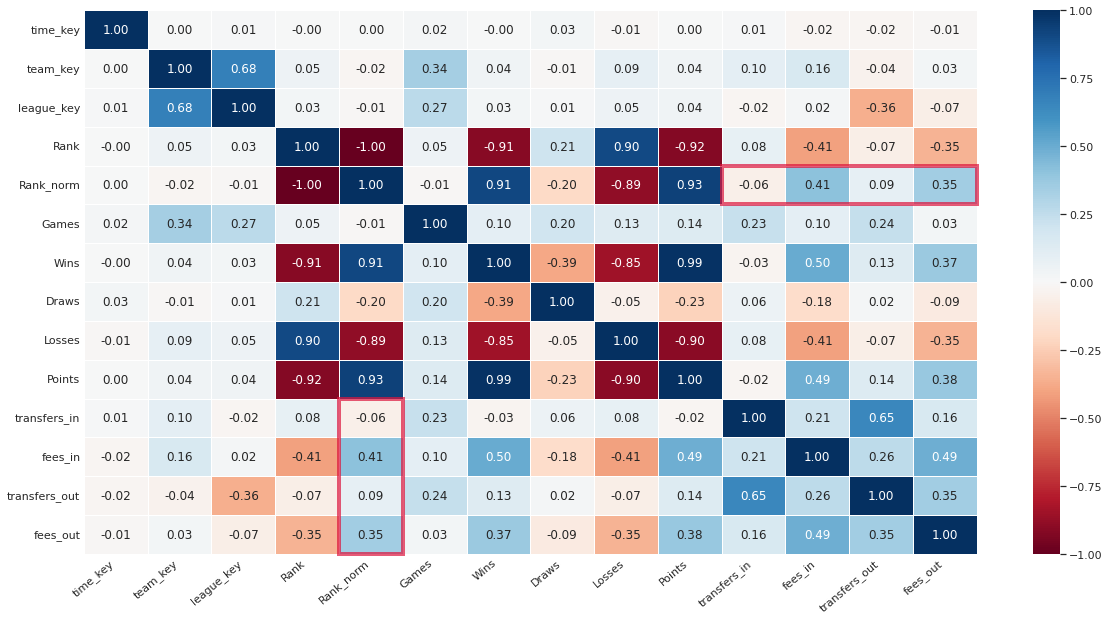

In [0]:
# Ajusta o tamanho da figura
plt.figure(figsize=(20, 10))  # Ajuste os valores conforme necessário

# Cria o heatmap
heatmap = sns.heatmap(performance_with_transfers_pd.corr().round(2), annot=True, fmt='.2f', cmap='RdBu', linewidths=.5)

# Ajuste a orientação da legenda no eixo x para ficar mais legível
plt.xticks(rotation=40, ha='right')

# Desenha 2 retangulos para facilitar visualização dos atributos do terroir
x, y, w, h = 4, 10, 1, 4
for _ in range(2):
    heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, alpha=0.7))
    # Inverte o retangulo para desenhar novamente
    x, y = y, x
    w, h = h, w
heatmap.tick_params(length=0)

# plt.tight_layout()
plt.show()

Observando as regiões marcadas em vermelho, da correlação dos atributos de performance e transferências, podemos verificar e confirmar os pontos discutidos nesta seção.

## 6.5 Qualidade dos Dados

Ambos os datasets escolhidos, apesar de não possuirem metadados a respeito dos atributos de suas tabelas, eram auto explicativos. No geral, poucas modificações precisaram ser feitas para garantir a integridade semântica dos dados. As dificuldades observadas foram descritas anteriormente e se dão principalmente no fato dos dados terem sido obtidos de fontes diferentes (semelhante a um problema do mundo real). Acredita-se que o método utilizado para relacionar os nomes dos times entre os dois datasets foi satisfatório e permitiu realizar análises interessantes e discutir as hipóteses levantadas neste trabalho.

## 6.6 Resultados e Trabalhos Futuros

Este trabalho cumpre seus objetivo, realiza a modelagem de um problema em um modelo de dados escalável na nuvem, realiza o ETL de dados de mais de uma origem e resolve os problemas levantados e propostos.

A respeito das hipóteses levantadas no início do MVP, pode-se observar que dentre as levantas, a que parece ser corroborada pelos dados avaliados é a de que os times que melhor performam em seus torneios tendem a gastar mais em contratações de jogadores. 

Para trabalhos futuros, além das perguntas principais, avaliadas neste trabalho, existem outras que também poderiam ser exploradas com uma análise mais detalhada dos dados, levando em consideração a posição dos jogadores contratados. Por exemplo:

- **Contratar atacantes aumenta as chances de um time fazer mais gols no campeonato?**
  - **Hipótese:** Supomos que a contratação de atacantes de qualidade pode resultar em um aumento significativo no número de gols marcados pelo time ao longo da temporada.

- **A contratação de defensores e goleiros melhora a defesa de um time, resultando em menos gols sofridos?**
  - **Hipótese:** Acreditamos que investir em posições defensivas pode levar a uma redução no número de gols sofridos, melhorando a solidez defensiva da equipe.